In [1]:
import crossref_commons.retrieval
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from src.crossref import current_timestamp
from src.github_api import ReplicationCode
from time import sleep

# GitHub API

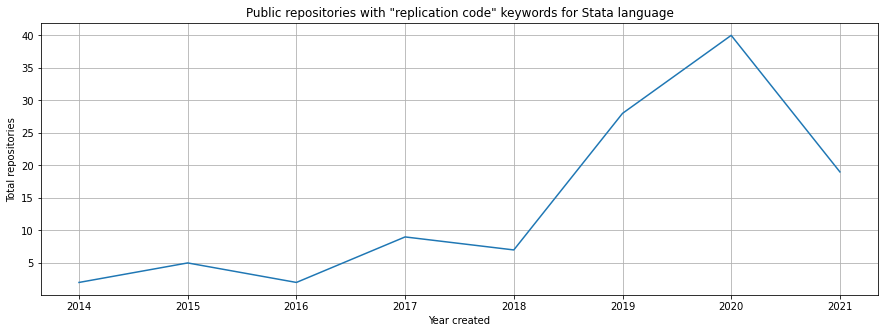

In [2]:
rc = ReplicationCode()
ghapi = rc.dataframe()
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot('created_at', 'count', data=ghapi)
plt.grid(b=True)
plt.title('Public repositories with "replication code" keywords for Stata language')
plt.xlabel('Year created')
plt.ylabel('Total repositories')
plt.savefig('img/replication-code-stata.png', bbox_inches = 'tight')

# AEA Deposits on ICPSR 

In [3]:
# check whether all data have been downloaded
!python3 src/aea.py --help
!python3 src/aea.py -j aer
!python3 src/aea.py -j aeri
!python3 src/aea.py -j app
!python3 src/aea.py -j pol
!python3 src/aea.py -j mac
!python3 src/aea.py -j mic
!python3 src/aea.py -j jel
!python3 src/aea.py -j jep
!python3 src/aea.py -j pandp

usage: aea.py [-h] [-j]

optional arguments:
  -h, --help       show this help message and exit
  -j , --journal   Journal name: ['aer', 'aeri', 'app', 'pol', 'mac', 'mic',
                   'jel', 'jep', 'pandp']
2021-06-29 00:51:44: https://www.aeaweb.org/journals/aer/issues
2021-06-29 00:51:46: https://www.aeaweb.org/journals/aeri/issues
2021-06-29 00:51:47: https://www.aeaweb.org/journals/app/issues
2021-06-29 00:51:48: https://www.aeaweb.org/journals/pol/issues
2021-06-29 00:51:50: https://www.aeaweb.org/journals/mac/issues
2021-06-29 00:51:51: https://www.aeaweb.org/journals/mic/issues
2021-06-29 00:51:52: https://www.aeaweb.org/journals/jel/issues
2021-06-29 00:51:53: https://www.aeaweb.org/journals/jep/issues
2021-06-29 00:51:55: https://www.aeaweb.org/journals/pandp/issues


In [4]:
aea = os.listdir('data/aea/raw')

In [5]:
def dataframe(file):
    with open(f'data/aea/raw/{file}', 'r') as f:
        data = json.load(f)

    df = pd.DataFrame(data['article'])
    df.insert(0, 'issue_url', data['issue_url'])
    df.insert(1, 'publication_date', data['publication_date'])

    return df

In [6]:
df = pd.concat([dataframe(x) for x in aea], sort=False)
df = df.reset_index(drop=True)
df['year'] = df.publication_date.apply(lambda x: x[-4:])
df['year'] = df.year.astype(str)

In [7]:
size = df.groupby('year')['icpsr'].size()
count = df.groupby('year')['icpsr'].count()
icpsr = pd.merge(size, count, on='year')
icpsr['proportion'] = icpsr.icpsr_y / icpsr.icpsr_x
icpsr = icpsr.reset_index()

In [8]:
def monthly():
    # will be used for monthly
    dates = []
    base_date = icpsr.publication_date.min()
    while base_date <= icpsr.publication_date.max():
        if base_date.day == 1:
            dates.append(base_date)
        base_date += timedelta(days=1)
    datesdf = pd.DataFrame(sorted(dates), columns=['publication_date'])

    icpsr = pd.merge(datesdf, icpsr, how='left', on='publication_date')
    icpsr.percent = icpsr.percent.fillna(0)
    
    return icpsr

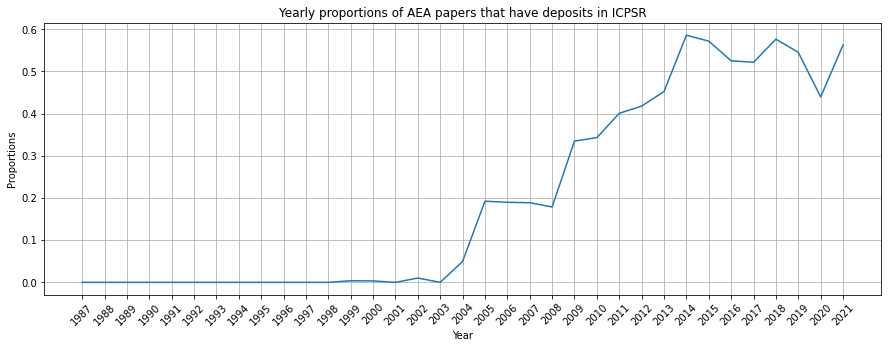

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot('year', 'proportion', data=icpsr)
plt.grid(b=True)
plt.title('Yearly proportions of AEA papers that have deposits in ICPSR')
plt.xticks(rotation = 45)
plt.xlabel('Year')
plt.ylabel('Proportions')
plt.savefig('img/aea-deposit-icpsr.png', bbox_inches = 'tight')

# Top 10 econ journals

In [10]:
def check_column(data, column):
    try:
        return data[column]
    except KeyError:
        return None
    
def dataframe(path, journal, file_name):
    df = []
    for j in journal:
        with open(f'{path}/{j}', 'r') as f:
            data = json.load(f)
            url = data['URL']
            print(f'{current_timestamp()}: {url}')
            d = {
                'doi': url,
                'title': check_column(data, 'title'),
                'author': check_column(data, 'author'),
                'publisher': check_column(data, 'publisher'),
                'created': check_column(data, 'created'),
                'has_replication': has_replication(url)

            }
            df.append(d)

    pd.DataFrame(df).to_csv(f'data/has-replication/{file_name}.csv', index=False)

## American Economic Association

AEA has three journals that are listed in top 10 econ journals according to IDEAS/RePEc. They are:
- American Economic Review (#1)
- Journal of Economic Literature (#2)
- Journal of Economic Perspectives (#10)

In [11]:
path = 'data/aea/raw'
os.system(f'rm -rf {path}/.ipynb_checkpoints')
aea = os.listdir(path)
aea = [json.load(open(f'{path}/{x}', 'r')) for x in aea]

In [12]:
for i in aea:
    for j in i['article']:
        j.update({'publication_date': i['publication_date']})

In [13]:
def has_replication(journal, file_name):
    df = pd.concat([pd.DataFrame(x['article']) for x in aea], sort=False)
    df = df.reset_index(drop=True)
    df['has_replication'] = df.icpsr.apply(lambda x: x != None)
    df[journal] = df.url.apply(lambda x: f'{journal}.' in x.lower())
    df = df[df[journal] == True]
    df = df[['url', 'icpsr', 'publication_date', 'has_replication']]
    df = df.reset_index(drop=True)
    df.to_csv(f'data/has-replication/{file_name}.csv', index=False)
    
has_replication('aer', 'american-economic-review')
has_replication('jel', 'journal-of-economic-literature')
has_replication('jep', 'journal-of-economic-perspectives')

## 3. The Quarterly Journal of Economics

In [14]:
path = 'data/crossref/s-oup-qjecon'
qje = os.listdir(path)

def has_replication(url):
    '''
    DOI example that has supplementary data: https://doi.org/10.1093/qje/qjaa038
    DOI example that doesn't have any supplementary data: http://dx.doi.org/10.1093/qje/qjr049
    '''

    status_code = None
    while status_code not in [200, 404]:
        try:
            res = requests.get(url, headers={'user-agent': os.environ['USER_AGENT']})
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            return content.find('h2', {'id': 'supplementary-data'}) != None
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass
        
dataframe(path, qje, 'the-quarterly-journal-of-economics')

2021-06-29 00:51:58: http://dx.doi.org/10.1093/qje/qjy003
2021-06-29 00:52:00: http://dx.doi.org/10.1093/qje/qjr031
2021-06-29 00:52:02: http://dx.doi.org/10.1093/qje/qjw033
2021-06-29 00:52:04: http://dx.doi.org/10.1093/qje/qju034
2021-06-29 00:52:06: http://dx.doi.org/10.1162/003355301753265561
2021-06-29 00:52:08: http://dx.doi.org/10.1162/qjec.122.1.119
2021-06-29 00:52:12: http://dx.doi.org/10.1093/qje/120.3.1155
2021-06-29 00:52:14: http://dx.doi.org/10.1093/qje/qjy033
2021-06-29 00:52:16: http://dx.doi.org/10.1093/qje/qjr026
2021-06-29 00:52:18: http://dx.doi.org/10.1093/qje/qjw017
2021-06-29 00:52:21: http://dx.doi.org/10.1093/qje/qjr032
2021-06-29 00:52:23: http://dx.doi.org/10.1093/qje/qju032
2021-06-29 00:52:25: http://dx.doi.org/10.1162/003355302753399508
2021-06-29 00:52:28: http://dx.doi.org/10.1162/qjec.2010.125.1.215
2021-06-29 00:52:28: http://dx.doi.org/10.1093/qje/qju017
2021-06-29 00:52:30: http://dx.doi.org/10.1162/qjec.2008.123.4.1679
2021-06-29 00:52:32: http://d

## 5. Journal of Political Economy

In [15]:
path = 'data/crossref/s-ucp-jpolec'
jpolec = os.listdir(path)

def has_replication(url):
    status_code = None
    while status_code not in [200, 404]:
        try:
            res = requests.get(url)
            sleep(1)
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            div = content.find('div', {'class': 'article__navbar__row tos-list__wrapper'})
            try:
                return 'supplemental material' in [x.text.lower() for x in div.find_all('li')]
            except:
                return False
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass
        
dataframe(path, jpolec, 'journal-of-political-economy')

2021-06-29 00:54:58: http://dx.doi.org/10.1086/504901
2021-06-29 00:55:00: http://dx.doi.org/10.1086/704071
2021-06-29 00:55:03: http://dx.doi.org/10.1086/680995
2021-06-29 00:55:05: http://dx.doi.org/10.1086/713733
2021-06-29 00:55:08: http://dx.doi.org/10.1086/653808
2021-06-29 00:55:12: http://dx.doi.org/10.1086/669915
2021-06-29 00:55:14: http://dx.doi.org/10.1086/701811
2021-06-29 00:55:18: http://dx.doi.org/10.1086/710334
2021-06-29 00:55:20: http://dx.doi.org/10.1086/679626
2021-06-29 00:55:23: http://dx.doi.org/10.1086/686035
2021-06-29 00:55:25: http://dx.doi.org/10.1086/649563
2021-06-29 00:55:27: http://dx.doi.org/10.1086/712786
2021-06-29 00:55:29: http://dx.doi.org/10.1086/706983
2021-06-29 00:55:31: http://dx.doi.org/10.1086/710535
2021-06-29 00:55:34: http://dx.doi.org/10.1086/705418
2021-06-29 00:55:36: http://dx.doi.org/10.1086/679497
2021-06-29 00:55:38: http://dx.doi.org/10.1086/664614
2021-06-29 00:55:40: http://dx.doi.org/10.1086/517935
2021-06-29 00:55:43: http://

## 6. Journal of Economic Growth 

In [16]:
path = 'data/crossref/s-kap-jecgro'
jecgro = os.listdir(path)

def has_replication(url):
    '''
    DOI example with Electronic supplementary material: https://doi.org/10.1007/s10887-020-09183-6
    DOI example with Supplementary Information: https://doi.org/10.1007/s10887-020-09185-4
    '''
    
    status_code = None
    while status_code not in [200, 404]:
        try:
            res = requests.get(url)
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            supplement = lambda keyword: content.find('section', {'data-title': keyword}).text.lower()
            try:
                return 'supplementary material' in supplement('Electronic supplementary material')
            except AttributeError:
                try:
                    return 'supplementary material' in supplement('Supplementary Information')
                except AttributeError:
                    return False
            except Exception as e:
                print(f'{current_timestamp()}: {url} has an error -> {e}')
                return False
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass

dataframe(path, jecgro, 'journal-of-economic-growth')

2021-06-29 01:15:41: http://dx.doi.org/10.1007/s10887-021-09188-9
2021-06-29 01:15:43: http://dx.doi.org/10.1007/s10887-012-9085-6
2021-06-29 01:15:44: http://dx.doi.org/10.1007/s10887-009-9036-z
2021-06-29 01:15:45: http://dx.doi.org/10.1007/s10887-009-9046-x
2021-06-29 01:15:47: http://dx.doi.org/10.1007/s10887-020-09182-7
2021-06-29 01:15:48: http://dx.doi.org/10.1007/s10887-013-9098-9
2021-06-29 01:15:49: http://dx.doi.org/10.1007/s10887-007-9013-3
2021-06-29 01:15:50: http://dx.doi.org/10.1007/s10887-005-1669-y
2021-06-29 01:15:51: http://dx.doi.org/10.1007/s10887-016-9127-6
2021-06-29 01:15:53: http://dx.doi.org/10.1007/s10887-016-9138-3
2021-06-29 01:15:55: http://dx.doi.org/10.1007/s10887-011-9077-y
2021-06-29 01:15:56: http://dx.doi.org/10.1007/s10887-019-09171-5
2021-06-29 01:15:57: http://dx.doi.org/10.1007/s10887-011-9076-z
2021-06-29 01:15:58: http://dx.doi.org/10.1007/s10887-006-9001-z
2021-06-29 01:15:59: http://dx.doi.org/10.1007/s10887-011-9061-6
2021-06-29 01:16:00: h

## 7. Review of Financial Studies

In [17]:
path = 'data/crossref/s-oup-rfinst'
rfinst = os.listdir(path)

def has_replication(url):

    status_code = None
    while status_code not in [200, 404]:
        try:
            res = requests.get(url, headers={'user-agent': os.environ['USER_AGENT']})
            print(res)
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            supplementary = content.find('h2', {'id': 'supplementary-data'})
            return supplementary != None
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass
        
dataframe(path, rfinst, 'the-review-of-financial-studies')

2021-06-29 01:20:11: http://dx.doi.org/10.1093/rfs/hhu042
<Response [200]>
2021-06-29 01:20:12: http://dx.doi.org/10.1093/rfs/hhu048
<Response [200]>
2021-06-29 01:20:12: http://dx.doi.org/10.1093/rfs/hhz073
<Response [200]>
2021-06-29 01:20:13: http://dx.doi.org/10.1093/rfs/hhy092
<Response [200]>
2021-06-29 01:20:13: http://dx.doi.org/10.1093/rfs/hhv017
<Response [200]>
2021-06-29 01:20:13: http://dx.doi.org/10.1093/rfs/hht005
<Response [200]>
2021-06-29 01:20:14: http://dx.doi.org/10.1093/rfs/hhz037
<Response [200]>
2021-06-29 01:20:14: http://dx.doi.org/10.1093/rfs/hhv070
<Response [200]>
2021-06-29 01:20:14: http://dx.doi.org/10.1093/rfs/hhu044
<Response [200]>
2021-06-29 01:20:14: http://dx.doi.org/10.1093/rfs/hht020
<Response [200]>
2021-06-29 01:20:15: http://dx.doi.org/10.1093/rfs/hhv056
<Response [200]>
2021-06-29 01:20:15: http://dx.doi.org/10.1093/rfs/hhaa011
<Response [200]>
2021-06-29 01:20:15: http://dx.doi.org/10.1093/rfs/hhw090
<Response [200]>
2021-06-29 01:20:15: htt

## 8. Econometrica 

In [18]:
path = 'data/crossref/s-wly-emetrp'
econometrica = os.listdir(path)

def has_replication(url):
    status_code = []
    while status_code not in [200, 404]:
        try:
            res = requests.get(url)
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            try:
                article = content.find('article')
                return 'replication' in article.text.lower()
            except:
                return False
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass
        
dataframe(path, econometrica, 'econometrica')

2021-06-29 01:22:06: http://dx.doi.org/10.3982/ecta17344
2021-06-29 01:22:07: http://dx.doi.org/10.3982/ecta10486
2021-06-29 01:22:10: http://dx.doi.org/10.3982/ecta14763
2021-06-29 01:22:12: http://dx.doi.org/10.3982/ecta16274
2021-06-29 01:22:13: http://dx.doi.org/10.3982/ecta17056
2021-06-29 01:22:15: http://dx.doi.org/10.3982/ecta15088
2021-06-29 01:22:17: http://dx.doi.org/10.3982/ecta17536
2021-06-29 01:22:18: http://dx.doi.org/10.3982/ecta15362
2021-06-29 01:22:19: http://dx.doi.org/10.3982/ecta14727
2021-06-29 01:22:20: http://dx.doi.org/10.3982/ecta19347
2021-06-29 01:22:21: http://dx.doi.org/10.3982/ecta14952
2021-06-29 01:22:21: http://dx.doi.org/10.3982/ecta15722
2021-06-29 01:22:22: http://dx.doi.org/10.3982/ecta11776
2021-06-29 01:22:23: http://dx.doi.org/10.3982/ecta13673
2021-06-29 01:22:25: http://dx.doi.org/10.3982/ecta18786
2021-06-29 01:22:27: http://dx.doi.org/10.3982/ecta13559
2021-06-29 01:22:29: http://dx.doi.org/10.3982/ecta14243
2021-06-29 01:22:30: http://dx.

## 9. Journal of Finance

In [19]:
path = 'data/crossref/s-bla-jfinan'
jfinan = os.listdir(path)

def _jfinan_crossref():
    dfs = []
    for i in jfinan:
        with open(f'{path}/{i}', 'r') as f:
            data = json.load(f)
        d = {
            'doi': data['URL'],
            'title': check_column(data, 'title'),
            'author': check_column(data, 'author'),
            'publisher': check_column(data, 'publisher'),
            'created': check_column(data, 'created'),
            'has_replication': False

        }

        dfs.append(pd.DataFrame([d]))

    df = pd.concat(dfs, sort=False)
    
    return df

def has_replication():
    status_code = None
    while status_code not in [200, 404]:
        try:
            url = 'https://afajof.org/supplements/'
            res = requests.get(url, headers={'user-agent': os.environ['USER_AGENT']})
            status_code = res.status_code
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass        
    content = BeautifulSoup(res.content, features='html.parser')
    div = content.find('div', {'class': 'site-content-contain'})
    doi = [x.text for x in div.find_all('p') if 'doi' in x.text]
    crossref = [crossref_commons.retrieval.get_publication_as_json(x) for x in doi]
    dfs = []
    for i in crossref:
        d = {
            'doi': i['URL'],
            'title': check_column(i, 'title'),
            'author': check_column(i, 'author'),
            'publisher': check_column(i, 'publisher'),
            'created': check_column(i, 'created'),
            'has_replication': True

        }
        dfs.append(pd.DataFrame([d]))
        file_name = i['DOI'].replace('/', '-')
        with open(f'{path}/{file_name}', 'w') as f:
            json.dump(i, f, indent=4)
    
    df = pd.concat(dfs, sort=False)
    
    return df

df = pd.concat([_jfinan_crossref(), has_replication()], sort=False)
df.to_csv('data/has-replication/journal-of-finance.csv', index=False)